## Objectif

Ce notebook a pour objectif d'explorer et d'analyser des images de radiographies pulmonaires pour classifier les cas de pneumonie et de normales en utilisant un réseau de neurones convolutif (CNN) pour la classification d'images de radiographies pulmonaires. L'ensemble de données contient deux classes : **PNEUMONIA** et **NORMAL**. 


## Étapes de Démarche

1. **Vérification de la Disponibilité du GPU**
2. **Chargement et Préparation des Données**
   - Chargement, redimensionnement, conversion en niveaux de gris, normalisation et restructuration des images.
3. **Visualisation des Données**
4. **Augmentation des Données**
5. **Définition et Entraînement du Modèle CNN**
6. **Évaluation du Modèle**
7. **Visualisation des Performances**
   - Matrice de confusion, rapport de classification et courbe ROC.
8. **Heatmaps des Activations**

## Interprétation et Résultats
- **Courbes d'Apprentissage** : convergence du modèle et relation entre la perte et l'exactitude.
- **Matrice de Confusion** : répartition des erreurs de classification.
- **Rapport de Classification** : mesures détaillées comme la précision, le rappel et le score F1.
- **Courbe ROC** : capacité du modèle à distinguer les classes à différents seuils.
- **Heatmaps des Activations** : caractéristiques extraites par les couches du modèle.ion des données d'entrée.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

## Vérification de la Disponibilité des GPU pour Accélérer l’Entraînement du Modèle

Pour entrainer un modele, le fait d'utiliser un GPU (processeur graphique) peut accélérer les calculs et ca réduit le temps d'entrainement.

In [8]:
print("Nb de GPU Disponible: ", len(tf.config.experimental.list_physical_devices('GPU')))

Nb de GPU Disponible:  0


## Définition des constantes

In [11]:
img_size = 150
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

## Chargement et prétraitement des images à partir des 2 dossiers

La fonction prend en entrée deux chemins de répertoire (data_dir1 et data_dir2) et retourne un tableau contenant les images redimensionnées et leurs étiquettes respectives.

In [14]:
def load_data(data_dir1, data_dir2):
    data = [] # initialisation d'une liste qui va stocker les imgs et les étiquettes (PNEUMONIA ou NORMAL)
    labels = ['PNEUMONIA', 'NORMAL'] # liste des labels possibles
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir) # consutruction de la path
        # on verifie si le chemin existe
        if(not (os.path.exists(path))):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir) # pour avoir le nom du répertoire qui correspond à l'étiquette
        class_num = labels.index(label) # conversion du nom de la classe en numéro
        # parcourir tous les fichiers du répertoire
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # on lit l'image au niveau gros (car les images qu'on a sont a noir et blanc)
                if img_arr is None:
                    print(f"Failed to read {img}. Skipping.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # redimensionnement de l'image
                data.append([resized_arr, class_num]) # ajout de l'image redimensionné et son label
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) # on convertit la liste data en un tableau NumPy, juste parceque c'est plus efficace et ensuite on le retourne

train_data = load_data(data_dir1, data_dir2)

## Visualisation du nombre d'images par classe

Pour mieux comprendre la distribution des images dans chaque classe (**PNEUMONIA** ou **NORMAL**), on crée une visualisation qui montre combien d'imahges sont présntes dans chaque classe. 
Ca permet d'évaluer si les données sont équilibrées (dans le cas contraire : sur-représentés ou sous-représentés)

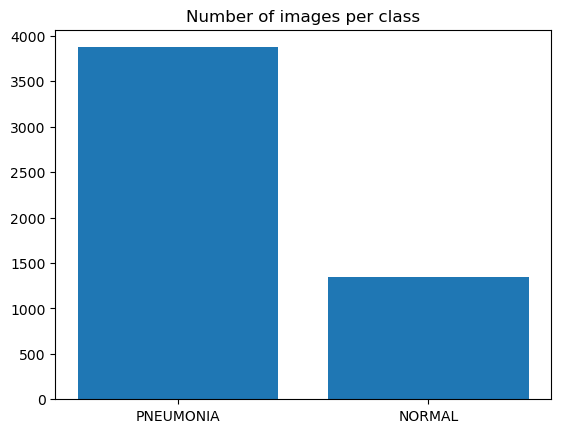

In [16]:
labels_count = [0, 0]
# on parcourt chaque élément de train_data (les données chargées et pré-traitées)
for item in train_data:
    labels_count[item[1]] += 1 # chaque élément 'item' est une liste qui a une img et son label de classe

# graphique
plt.bar(['PNEUMONIA', 'NORMAL'], labels_count)
plt.title('Number of images per class')
plt.show()

## Prétraitement des Données : Normalisation et Reshaping

Avant d'entrainer un modele, il faut toujours de préparer les données correctement.

- **Séparer les données en Feature et Labels** : 
  -  Features : images
  -  Labels : labels (étiquettes) qui indiquent la classe de chaque image

- **Normaliser** : 
  - Chaque pixel d'une image a une valeur entre 0 et 255.
  - Normaliser signifie diviser ces valeurs par 255 pour qu'elles soient entre 0 et 1.
  - Cela facilite l'entraînement du modèle parceque les valeurs sont plus petites et plus uniformes. Cela peut améliorer les performances du modèle.

- **Reshaper** :
  - Les images sont des tableaux de nombres (valeurs des pixels).
  - Reveut direignifie réorganiser ces tableaux pour qu'ils aient une forme spécifique.
  - On veut que chaque image ait la forme (nombre d'images, 150, 150, 1).
  - Cela indique qu'on a un certain nombre d'images, que chaque image a une taille de 150x150 pixels, et qu'elle est en niveaux de gris (1 canal de couleur).

In [20]:
# separation des caracteristiques et des etiquettes
def separate_features_labels(data):
    features, labels = [], [] # init de 2 listes vides qui
    for feature, label in data:
        features.append(feature) # ajout du feature à la liste
        labels.append(label) # ajout du label à la liste
    return np.array(features), np.array(labels) # on convertit les listes features et labels en tableaux NumPy et on retourne ces tableaux

x_train, y_train = separate_features_labels(train_data)

# normalisation des donnees
x_train = x_train / 255.0
x_train = x_train.reshape(-1, img_size, img_size, 1)

## Vérification des Données et Augmentation des Images

Avant d'entrainer un modele, il faut aussi vérifier si les données sont bien chargées et non vides.
Si les tableaux de données ```x_train``` et ```y_train``` contiennent des données, alors on peut générer des images pour augmenter les données d'entrainement.

Cette augmentation des données aide à enrichir la diversité des images d'entrainement.

In [23]:
# S'assurer que les données ne sont pas vides
if x_train.size == 0 or y_train.size == 0:
    print("Training data is empty. Please check the data loading process.")
else:
    datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )
    datagen.fit(x_train)

## Affichage de quelques exemples d'images augmentées

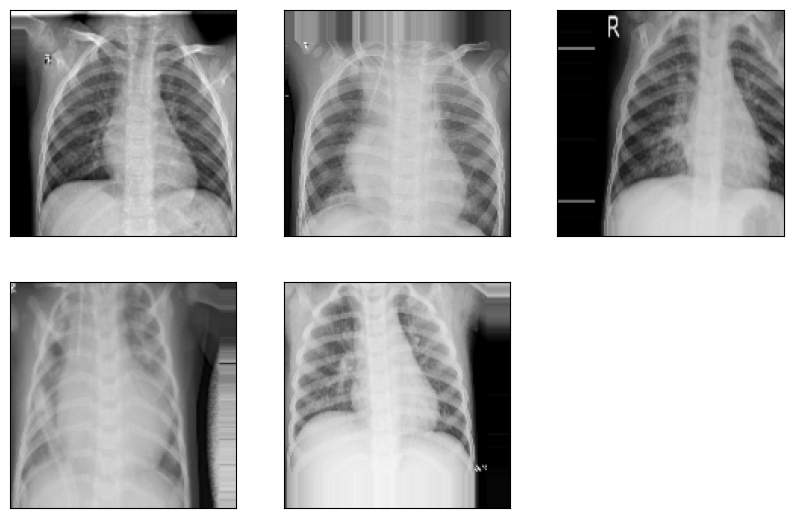

In [26]:
def display_augmented_images(datagen, x_train, y_train):
    plt.figure(figsize=(10, 10)) # création d'une nouvelle figure de taille 10x10 pouces
    # pour generer et afficher les images augmentées et chaque lot(batch) contient 5 images
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=5):
        # pour afficher chaque image dans le lot
        for i in range(5):
            plt.subplot(330 + 1 + i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(x_batch[i].reshape(img_size, img_size), cmap='gray')
        plt.show()
        break

display_augmented_images(datagen, x_train, y_train)

## Création d'un Modèle CNN (Convolutional Neural Network)

Un CNN est crée pour traiter les images et extraire des caractéristiques importantes à différentes niveaux de complexité.
Pour créer un modele de CNN, il faut suivre ces étapes :

- **Couche de Convolution** : Extrait les caractéristiques de l'image.
- **Couche de Pooling** : Réduit la taille de l'image tout en conservant les caractéristiques importantes.
- **Couche de Dropout** : Réduit le surapprentissage en désactivant aléatoirement des neurones.
- **Couche Dense** : Effectue la classification.
- **Compilation** : Utilise l'optimiseur Adam et la perte cross-entropy pour entraîner le modèle.

In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)), # couche de convolution avec 32 filtres de taille 3x3
    MaxPooling2D((2, 2)), # couche de pooling maximal avec une fenetre de taille 2x2
    Dropout(0.2), # couche de dropout avec un taux de 0,2 (20% de neurones sont désactivés de manière random pour éviter le "surapprentissage")
    
    Conv2D(64, (3, 3), activation='relu'), # 2ème couche  de convolution avec 64 filtres de taille 3x3 et une fonction d'activation "relu"
    MaxPooling2D((2, 2)), # 2ème couche de Maxpooling maximal avec une fenetre de taille 2x2
    Dropout(0.2), # 2ème couche de dropout avec un taux de 0.2
    
    Flatten(), # couche de mise à plat (flattening) pour convertir les données 2D en vecteur 1D
    Dense(128, activation='relu'), # couche de dense avec 128 neurones et une fonction d'activation "relu"
    
    Dropout(0.5), # 3ème couche de dropout avdc un taux de 0.5
    Dense(1, activation='sigmoid') # couche de sortie dense avec 1 neurone et une fonction d'activation "sigmoid"
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compilation du modèle

C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Configuration des Callbacks pour l’Entraînement du Modèle

Les callbacks permettent de surveiller et contoler le processus d'entrainement du modele. Ils permettent d'ajuster des paramètres automatiquement ou même d'interrompre l'entrainement.

- **Ajustement du taux d'apprentissage** : ce taux permet de déterminer la vitesse à laquelle le modele apprend. Si le modele n'améliore plus ses résultats, alors on peut utiliser un callback pour réduire le taux d'apprentissage  automatiquement. Ca permet au modele d'apprendre plus doucement et de trouver de meilleures solutions.
- **Arret Anticipé (Early-stopping)** : arret de l'entrainement du modele si la performance ne s'améliore plus. Ca evite d'entrainer le modele trop longtemps et de gaspiller des trucs et ça évite su sur-apprentissage
- **Entrainement du modele avec les données augmentées** : après avoir configuré les callbacks, on enrtaine le modele avec les données augemntées avec ces callbacks pour ajuster le taux d'apprentissage et interrompre l'entrainement si besoin.

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.001)
early_stop = EarlyStopping(monitor='loss', patience=3)  # Callback pour arrêter l'entraînement quand la perte (loss) cesse de diminuer

# Entraînement du modèle avec les données augmentées générées par datagen
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=10, callbacks=[reduce_lr, early_stop])

# Evaluation du modèle pour s'assurer qu'il a été "appelé" avec des données d'entrée
model.evaluate(x_train, y_train, verbose=0)

Epoch 1/10


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 376ms/step - accuracy: 0.7250 - loss: 0.8855 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.7397 - loss: 0.4740 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.7493 - loss: 0.4418 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 406ms/step - accuracy: 0.7734 - loss: 0.4072 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 370ms/step - accuracy: 0.8290 - loss: 0.3726 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 356ms/step - accuracy: 0.8607 - loss: 0.3344 - learning_rate: 0.0010
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 372ms/step - accuracy: 0.8730 - loss: 0.3224 - learning_rate: 0.0010
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 393ms/step - accuracy: 0.8977 - loss: 0.2965 - learning_rate: 0.0010
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 380ms/step - accuracy: 0.8956 - loss: 0.2809 - learning_rate: 0

[0.19337528944015503, 0.9380751252174377]

## Courbes de Perte et d'Exactitude

Permet de suivre l'évolution de la performance du modele en cours de l'entrainement.

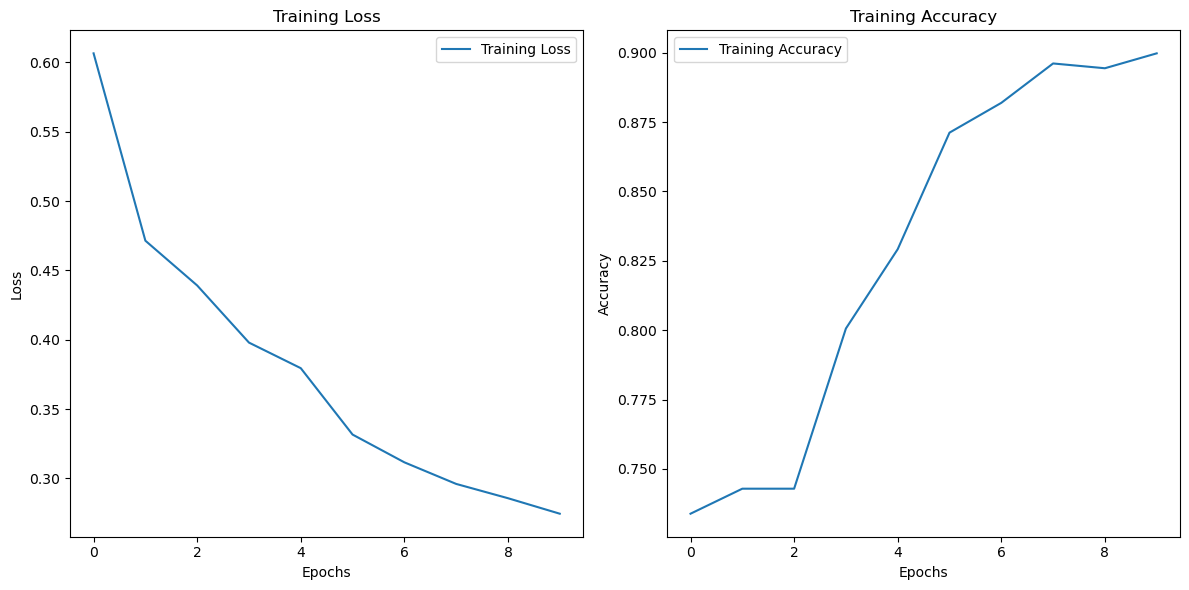

In [34]:
# Affichage des courbes d'apprentissage
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    #  courbe de la perte
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # courbe de l'exactitude
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

## Évaluation du Modèle

- **Précision du modele** :
  - **Très bien** si > 90%
  - **Bien** si > 80%
  - **Pas assez bon** si < 80%

- **Perte du modele** :
  - **Très bien** si < 0.1
  - **Bien** si < 0.2
  - **Pas assez bon** si > 0.2 si > 0.2

In [37]:
scores = model.evaluate(x_train, y_train, verbose=0) # evaluation
print(f"Model accuracy: {scores[1]*100:.2f}%")
print(f"Model loss: {scores[0]:.4f}")

Model accuracy: 93.81%
Model loss: 0.1934


## Affichage de quelques prédictions

163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step


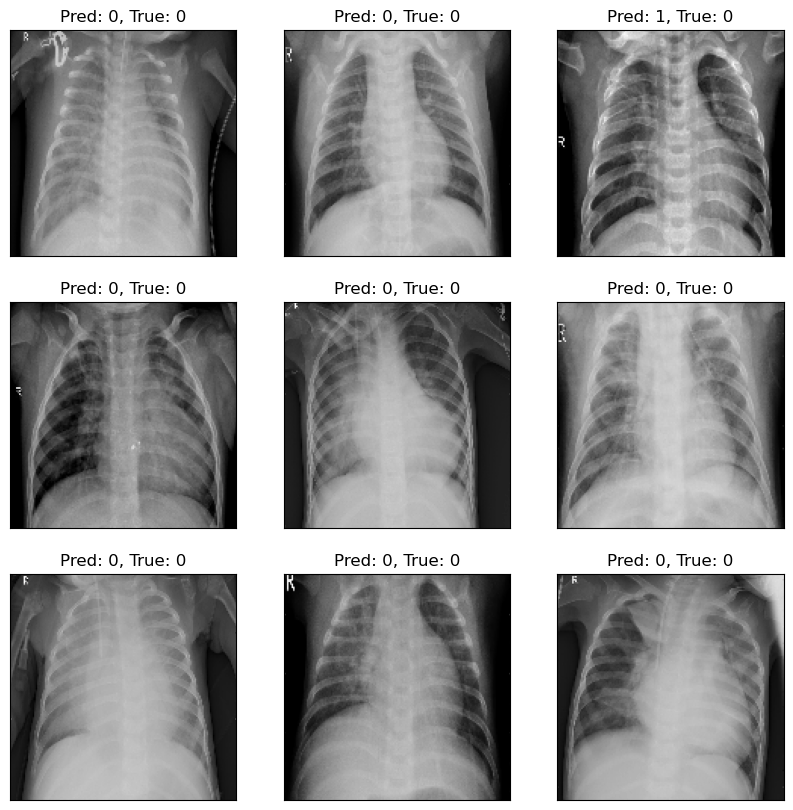

In [40]:
# les 3 arguments : le modele entraine, x_train : les caractéristiques de l'entainement, y_train : les labels d'entrainement
def display_predictions(model, x_train, y_train):
    plt.figure(figsize=(10, 10)) # nouvelle figure avec taille 10x10
    predictions = (model.predict(x_train) > 0.5).astype("int32") # utilisation du modle pour faire des predictions sur x_train. ces predictions sont converties en valeurs binaires (0 ou 1) en comparant les probabilités prédites à 0.5
    # parcours des 9 premieres imgs de x_train
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_train[i].reshape(img_size, img_size), cmap='gray')
        plt.title(f"Pred: {predictions[i][0]}, True: {y_train[i]}")
    plt.show()

display_predictions(model, x_train, y_train)

## Matrice de Confusion et Rapport de classification

- **Matrice de confusion** : Montre combien d'images ont été correctement ou incorrectement classées par chaque classe (PNEUMONIA ou NORMAL).
- **Rappel(ou Sensibilisation ou Taux de vrais positifs - TPR)** :
    - Proportion d'images qui ont une pnemonie correctement identifiées par le modele.
    - Plus le rappel/TPR est plus élevé, mieux le modele détecte le cas de pneumonie.
- **F1-score** :
  - Combine la précision et le rappel en 1 seule valeure.
  - Plus le F1-score est élevé, mieux est l'équilibre entre la précision et le rappel/TPR.

163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step


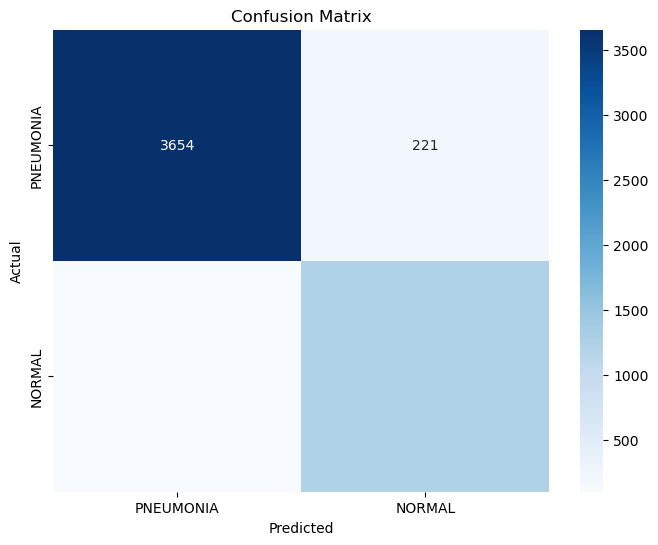

Another way of representation of the Confusion Matrix:
 [[3654  221]
 [ 102 1239]]
Classification Report:
               precision    recall  f1-score   support

   PNEUMONIA       0.97      0.94      0.96      3875
      NORMAL       0.85      0.92      0.88      1341

    accuracy                           0.94      5216
   macro avg       0.91      0.93      0.92      5216
weighted avg       0.94      0.94      0.94      5216



In [43]:
# Utilisation du modèle pour faire des prédictions sur x_train.
# Les prédictions sont converties en valeurs binaires (0 ou 1) en comparant les probabilités prédites à 0.5.
y_pred = (model.predict(x_train) > 0.5).astype("int32")

# Calcul de la matrice de confusion en comparant les labels réels (y_train) avec les prédictions du modèle (y_pred)
cm = confusion_matrix(y_train, y_pred)

# Diagramme de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
print("Another way of representation of the Confusion Matrix:\n", cm)

# Génération d'un rapport de classification avec la précision, le rappel, le F1-score et le support pour chaque classe
cr = classification_report(y_train, y_pred, target_names=['PNEUMONIA', 'NORMAL'])
print("Classification Report:\n", cr)

## Affichage de courbe ROC

**Courbe permet d'évaluer la performance d'un modele**. Elle montre la relation entre le taux de vrais positifs (TPR) et le taux de faux positifs (FPR) à différents seuils de décision.

- **Taux de Vrais Positifs (TPR)** : Le Taux de Vrais Positifs (sensibilité ou rappel) permet de mesurer la capacité du modèle à détecter les cas positifs.

-  **Taux de Faux Positifs (FPR)** : Le Taux de Faux Positifs mesure la proportion de cas négatifs qui sont incorrectement classés comme positifs.

- **Courbe ROC** : La courbe ROC est tracée en mettant le TPR (axe des ordonnées) en fonction du FPR (axe des abscisses). Chaque point sur la courbe représente un seuil de décision différent.

- **Aire sous la Courbe (AUC)** : AUC est une mesure globale de la performance du modèle. Plus l'AUC est proche de 1, meilleure est la performance du modèle.
  - AUC = 1 : modèle parfait
  - AUC = 0.5 : modèle qui ne fait pas mieux que le hasard

### Interprétation
- **TPR élevé** : Le modèle est bon pour détecter les cas positifs.
- **FPR faible** : Le modèle fait peu d'erreurs en classant les cas négatifs comme positifs.
- **Courbe ROC proche de la diagonale** : Le modèle a une performance similaire à un modèle aléatoire.
- **Courbe ROC proche du coin supérieur gauche** : Le modèle a une bonne performance.

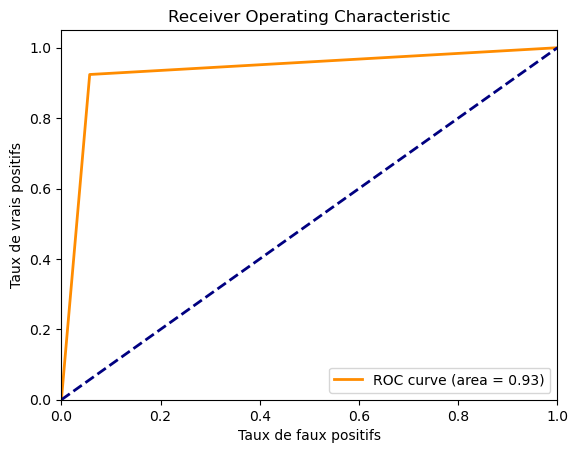

In [46]:
fpr, tpr, _ = roc_curve(y_train, y_pred) # calculs des taux de FPR et TPR
roc_auc = auc(fpr, tpr) # calcul de l'aire sous la courbe

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Visualisation des activations des couches du modele

Affichage des 1ères couches du modele CNN pour une image donnée.
Les heatmaps montent comment chaque couche transforme les données d'entrée et ça permet d'avoir une vue sur ce que le modele "voit". donc ça aide à comprendre comment le modele extrait et traire les caractéristiques des images.

In [51]:
def display_activation(model, img):
    img_tensor = np.expand_dims(img, axis=0)  # Expand dimensions to match model input
    img_tensor = img_tensor / 255.0  # Normalize the image

    # Extracts the outputs of the top 8 layers
    layer_outputs = [layer.output for layer in model.layers[:8]]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

    # Returns a list of Numpy arrays: one array per layer activation
    activations = activation_model.predict(img_tensor)

    layer_names = [layer.name for layer in model.layers[:8]]  # Names of the layers for plotting

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations):  # Displays the feature maps
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # Feature map shape (1, size, size, n_features)
        n_cols = n_features // images_per_row  # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):  # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                if channel_image.std() != 0:  # Avoid division by zero
                    channel_image -= channel_image.mean()  # Post-process the feature to make it visually palatable
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

for i in range(5):
    display_activation(model, x_train[i].reshape(img_size, img_size, 1))

print("Full data augmentation with shift and model evaluation complete.")

ValueError: The layer sequential has never been called and thus has no defined input.